# Customer segmentation (clustering)

__Customer segmentation__ is the process of dividing a customer base into smaller groups or segments based on similar characteristics such as demographics, behaviors, interests, and needs. The goal of customer segmentation is to identify groups of customers who have different needs, preferences, or purchasing behaviors, and to tailor marketing messages, products, and services to these specific groups. Customer segmentation can help businesses improve customer satisfaction, loyalty, and retention by delivering personalized experiences and relevant offers to each segment. It can also help businesses optimize their marketing budgets and resources by focusing on the most profitable customer segments.

Today we will work with customer transaction dataset. It consists of two parts:

1. Transaction logs of users
2. Response of the user on the marketing campaign

In [1]:
import pandas as pd

transactions = pd.read_csv("Retail_Data_Transactions.csv")
transactions.trans_date = pd.to_datetime(transactions.trans_date)
transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [2]:
responses = pd.read_csv("Retail_Data_Response.csv")
responses.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


One of the most popular ways to perform customer segmentation is to use RFM analysis.

RFM analysis is a marketing technique used to analyze customer behavior based on three factors: Recency, Frequency, and Monetary value.

* __Recency__: Refers to how recently a customer has made a purchase. Customers who have made a purchase more recently are considered to be more engaged and valuable to a business.

* __Frequency__: Refers to how often a customer makes purchases. Customers who make purchases more frequently are considered to be more loyal and valuable to a business.

* __Monetary value__: Refers to the total amount of money a customer has spent on purchases. Customers who have spent more money are considered to be more valuable to a business.

RFM analysis uses these three factors to assign scores to each customer, based on their behavior. The scores are usually based on a scale of 1 to 5, with 5 being the highest score. Once the scores have been assigned, customers can be segmented into different groups based on their scores.

For example, customers with high scores in all three factors (recency, frequency, and monetary value) are considered to be the most valuable and may be targeted with special promotions or offers to retain their loyalty. Customers with low scores in all three factors may be less valuable and may not receive as much attention or marketing resources.


So, to calculate `Recency`, we need to define the date of analysis. Let us consider the last date in the data for this purpose.

In [3]:
last_date = transactions.trans_date.max()

The segmentation is usually performed at the user level. So, we should aggregate the data on the user level.

In [4]:
transactions["frequency"] = 1
rfm_table = transactions.groupby("customer_id").agg({
    "trans_date": "max",
    "tran_amount": "sum",
    "frequency": "sum"
}).rename({"tran_amount": "monetary"}, axis=1)

Now, we can define the recency: number of days from the last transaction by the user

In [5]:
rfm_table["recency"] = (last_date - rfm_table.trans_date).dt.days
rfm_table = rfm_table[["recency", "frequency", "monetary"]]
rfm_table.head()

,recency,frequency,monetary
customer_id,,,
CS1112,61,15,1012
CS1113,35,20,1490
CS1114,32,19,1432
CS1115,11,22,1659
CS1116,203,13,857


In [6]:
quartiles = rfm_table.quantile(q=[0.25,0.50,0.75])
quartiles

,recency,frequency,monetary
0.25,22.0,14.0,781.0
0.50,53.0,18.0,1227.0
0.75,111.0,22.0,1520.0


In [7]:
import numpy as np

rfm_table["recency_score"] = 3 - np.searchsorted(quartiles["recency"].values, rfm_table.recency)
rfm_table["frequency_score"] = np.searchsorted(quartiles["frequency"].values, rfm_table.frequency)
rfm_table["monetary_score"] = np.searchsorted(quartiles["monetary"].values, rfm_table.monetary)
rfm_table["segment"] = rfm_table["recency_score"].astype(str) + rfm_table["frequency_score"].astype(str) + rfm_table["monetary_score"].astype(str)
rfm_table.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,segment
customer_id,,,,,,,
CS1112,61,15,1012,1,1,1,111
CS1113,35,20,1490,2,2,2,222
CS1114,32,19,1432,2,2,2,222
CS1115,11,22,1659,3,2,3,323
CS1116,203,13,857,0,0,1,001


Now, we can calculate the average response rate in different customer segments.

In [8]:
rfm_table = responses.join(rfm_table, on="customer_id")
rfm_table["num_responses"] = rfm_table.response.copy()

rfm_table.groupby("segment").agg({
    "response": "mean",
    "num_responses": "sum",
}).sort_values("response", ascending=False).reset_index().head(10).round(4)

,segment,response,num_responses
0,231,0.5000,2
1,033,0.2883,47
2,133,0.2615,85
3,331,0.2500,1
4,220,0.2500,1
5,232,0.2500,4
6,023,0.2273,15
7,022,0.2090,51
8,123,0.2041,20
9,032,0.1667,2


In [9]:
rfm_table["is_upper"] = (rfm_table.recency_score >= 2) & (rfm_table.frequency_score >= 2) & (rfm_table.monetary_score >= 2)

rfm_table.groupby("is_upper").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
}).reset_index().round(4)

,is_upper,response,customer_id,num_responses
0,False,0.0853,5124,437
1,True,0.1193,1760,210


In [10]:
rfm_table["total_upper"] = rfm_table.recency_score + rfm_table.frequency_score + rfm_table.monetary_score > 5


rfm_table.groupby("total_upper").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
}).reset_index().round(4)

,total_upper,response,customer_id,num_responses
0,False,0.0630,4349,274
1,True,0.1471,2535,373


Looks like using the simple RFM score we can select segments with higher response rate. However, may be we can create different groups based on this features with even higher rates?

Let us visualize features. It is easily to analyze plots in two dimensions. So, we need to reduce the number of dimensions in our data.

We can do it in different ways. The most popular ones are the PCA and TSNE. 

__PCA stands for Principal Component Analysis.__ It is a statistical technique used to simplify and reduce the complexity of a large dataset by transforming the original variables into a smaller set of uncorrelated variables called principal components.

PCA works by identifying the underlying patterns or relationships in a dataset and transforming the variables into a new coordinate system, where the first principal component explains the largest possible variance in the data, followed by the second principal component, and so on. The principal components are orthogonal to each other, meaning they are uncorrelated, and are sorted by their importance in explaining the variance in the original data

__t-SNE (t-distributed stochastic neighbor embedding)__ is a machine learning algorithm used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D.

t-SNE works by first calculating pairwise similarities or distances between all data points in the high-dimensional space. It then constructs a probability distribution in the low-dimensional space, and tries to minimize the difference between this probability distribution and the pairwise similarities in the high-dimensional space.

The algorithm iteratively optimizes the positions of the data points in the low-dimensional space until it reaches a stable configuration that best represents the relationships between the data points in the high-dimensional space. t-SNE is particularly good at preserving the local structure of the data, meaning that nearby points in the high-dimensional space are also nearby in the low-dimensional space.

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(2)
rfm_pca = pca.fit_transform(rfm_table[["recency", "frequency", "monetary"]].values)

tsne = TSNE(2)
rfm_tsne = tsne.fit_transform(rfm_table[["recency", "frequency", "monetary"]].values)

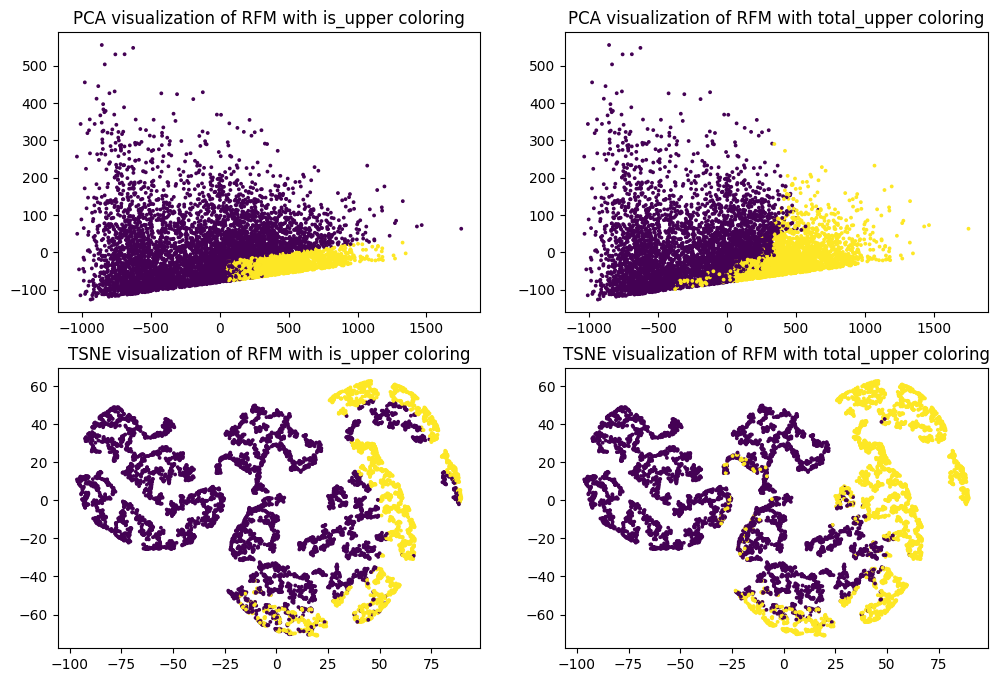

In [12]:
from matplotlib import pyplot as plt

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot the data in the first subplot
axs[0, 0].scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm_table.is_upper, s=3)
axs[0, 0].set_title('PCA visualization of RFM with is_upper coloring')

# Plot the data in the second subplot
axs[0, 1].scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm_table.total_upper, s=3)
axs[0, 1].set_title('PCA visualization of RFM with total_upper coloring')

# Plot the data in the third subplot
axs[1, 0].scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=rfm_table.is_upper, s=3)
axs[1, 0].set_title('TSNE visualization of RFM with is_upper coloring')

# Plot the data in the fourth subplot
axs[1, 1].scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=rfm_table.total_upper, s=3)
axs[1, 1].set_title('TSNE visualization of RFM with total_upper coloring')

plt.show()

We can found that total_upper column covers more closests point but not uniformly. So, may be we can apply some clustering techniques to define better segments.

Clustering is a machine learning technique that involves grouping together similar data points based on some similarity or distance measure.

The objective of clustering is to identify patterns or structure in a dataset by dividing the data into clusters, where each cluster consists of data points that are more similar to each other than to data points in other clusters.

Let us try two methods: k-means and agglomerative clustering

__K-means__ is a centroid-based clustering algorithm, which partitions a dataset into k clusters, where k is a user-defined parameter. The algorithm works by iteratively assigning each data point to the nearest cluster center and then updating the cluster centers based on the mean of the data points assigned to each cluster. The process continues until the cluster centers converge or a maximum number of iterations is reached.

__Agglomerative clustering__ is a hierarchical clustering algorithm, which builds a hierarchy of clusters by iteratively merging the two closest clusters based on some distance or similarity metric. The algorithm starts by treating each data point as a separate cluster and then merges the two closest clusters into a new cluster until all data points belong to a single cluster or a desired number of clusters is reached.

Both k-means and agglomerative clustering have their own strengths and weaknesses and are suited to different types of data and applications. K-means is often faster and more scalable than agglomerative clustering, but it assumes that clusters are spherical and equally sized, which may not be appropriate for all datasets. Agglomerative clustering can handle more complex cluster shapes and sizes, but it can be computationally expensive for large datasets.

Selecting the appropriate number of clusters for K-means is an important step in the clustering process. There are several methods that can be used to determine the optimal number of clusters, including:

1. __Elbow method__: Plot the within-cluster sum of squares (WCSS) as a function of the number of clusters. The WCSS is the sum of the squared distances between each data point and its nearest cluster center. The idea is to select the number of clusters at the point where the rate of decrease in WCSS starts to level off, which resembles an elbow shape in the plot.

2. __Silhouette method__: Compute the silhouette coefficient for each data point, which measures how similar a data point is to its own cluster compared to other clusters. The silhouette coefficient ranges from -1 to 1, with higher values indicating better clustering. Compute the average silhouette coefficient for different numbers of clusters and select the number of clusters with the highest average silhouette coefficient.

3. __Gap statistic__: Compare the WCSS for the actual data to the WCSS for a reference null distribution. The idea is to select the number of clusters where the gap between the actual WCSS and the expected WCSS for the null distribution is the largest.

4. __Domain knowledge__: Consider the domain knowledge and business requirements to select the appropriate number of clusters based on the context and the specific problem being solved.

It's important to note that there is no single "correct" method for selecting the number of clusters, and different methods may yield different results. Therefore, it's a good practice to try multiple methods and compare the results to select the most appropriate number of clusters for the specific problem at hand.


Let us consider the simplest one -- the Elbow method

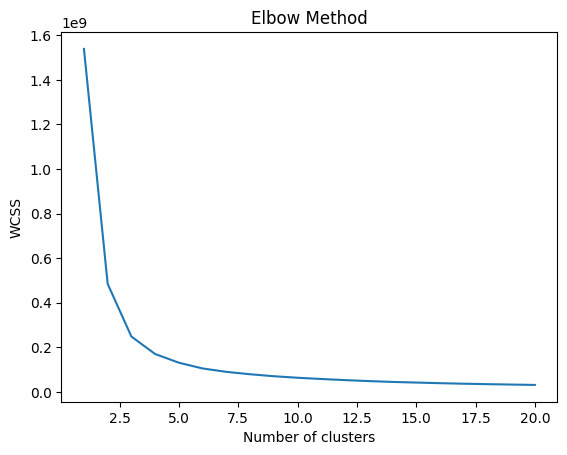

In [13]:
from sklearn.cluster import KMeans

X = rfm_table[["recency", "frequency", "monetary"]].values

wcss = []

# Fit K-means models for different k values and compute the WCSS
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the WCSS as a function of the number of clusters
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Looks like we can select the number of clusters equal to 5.

In [14]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
rfm_table["kmeans"] = kmeans.fit_predict(X)

rfm_table.groupby("kmeans").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

,kmeans,response,customer_id,num_responses,monetary,recency,frequency
2,2,0.0120,1411,17,509.9100,119.7201,11.6194
0,0,0.0533,1145,61,872.6017,85.1799,15.2638
4,4,0.0882,1792,158,1226.8549,78.2243,17.8080
1,1,0.1542,1725,266,1537.4812,59.8777,21.7838
3,3,0.1788,811,145,1915.0271,50.5166,26.6436


In [15]:
rfm_table["kmeans_upper"] = (rfm_table.kmeans == 1) | (rfm_table.kmeans == 3)

rfm_table.groupby("kmeans_upper").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4)

,kmeans_upper,response,customer_id,num_responses,monetary,recency,frequency
0,False,0.0543,4348,236,900.9052,93.5221,15.1297
1,True,0.1621,2536,411,1658.2185,56.8841,23.3379


So, we can select clusters number `1` and `3` from kmeans to perform our marketing campaign.

In case when we have some labeling, we can estimate the quality of cluster assignment using Rand Index.

The __Rand index__ is a measure of the similarity between two sets of cluster assignments, and can be used to evaluate the quality of clustering results. One approach to using the Rand index to select the optimal number of clusters is to compute the Rand index for a range of different numbers of clusters, and choose the number of clusters that produces the highest Rand index.

In [25]:
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np

# Set the range of cluster numbers to try
n_clusters_range = range(2, 21)

# Compute the Rand index for each number of clusters
rand_indices = []
for n_clusters in n_clusters_range:
    agg = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    labels = agg.fit_predict(X)
    rand_index = adjusted_rand_score(rfm_table.response, labels)
    rand_indices.append(rand_index)

# Choose the number of clusters with highest Rand index
optimal_n_clusters = n_clusters_range[np.argmax(rand_indices)]

print(f"Optimal number of clusters: {optimal_n_clusters}")

Optimal number of clusters: 3


In [26]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
rfm_table["kmeans"] = kmeans.fit_predict(X)

rfm_table.groupby("kmeans").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

,kmeans,response,customer_id,num_responses,monetary,recency,frequency
1,1,0.0225,2088,47,601.9420,109.4804,12.7759
2,2,0.0924,2836,262,1228.3473,75.4221,17.9256
0,0,0.1724,1960,338,1725.4745,55.3061,24.2122


Lets take a look at the agglomerative clustering. It iteravely aggreagates different points in the clsuters. So, we can define hierarchy of agregations and can select the depth of it as optimal clustering.

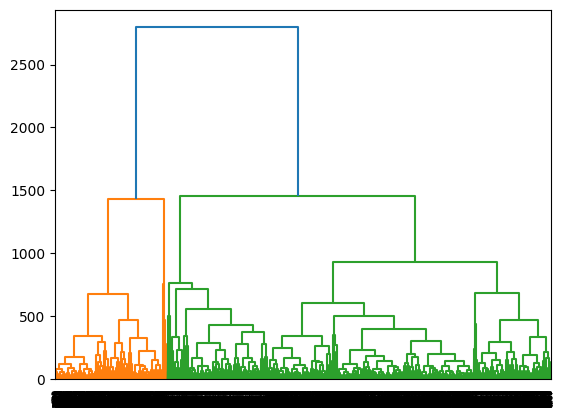

/Users/mkiseljov/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,agc,response,customer_id,num_responses,monetary,recency,frequency
0,0,0.0714,5319,380,1003.7755,87.7046,16.1686
1,1,0.1706,1565,267,1778.4639,53.9240,24.8997


In [16]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X, method='complete')
dn = hierarchy.dendrogram(Z)
plt.show()

agc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
rfm_table["agc"] = agc.fit_predict(X)

rfm_table.groupby("agc").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

The optimal number of clusters here is 2, but the right cluster has two many values. So, we can iteratively split it on several parts.

In [17]:
agc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
rfm_table["agc"][rfm_table["agc"] == 0] = 2 + agc.fit_predict(X[rfm_table["agc"] == 0])

rfm_table.groupby("agc").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

/Users/mkiseljov/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/var/folders/y2/1spg1s5d0bg04p_z_9sf4kd00000gn/T/ipykernel_36783/1655662837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_table["agc"][rfm_table["agc"] == 0] = 2 + agc.fit_predict(X[rfm_table["agc"] == 0])


,agc,response,customer_id,num_responses,monetary,recency,frequency
2,3,0.0129,1391,18,508.5054,123.2092,11.5751
1,2,0.0922,3928,362,1179.1627,75.1316,17.7953
0,1,0.1706,1565,267,1778.4639,53.9240,24.8997


Let us do it one more time for the cluster with id 2.

In [18]:
agc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
rfm_table["agc"][rfm_table["agc"] == 2] = 4 + agc.fit_predict(X[rfm_table["agc"] == 2])

rfm_table.groupby("agc").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

/Users/mkiseljov/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/var/folders/y2/1spg1s5d0bg04p_z_9sf4kd00000gn/T/ipykernel_36783/599257303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_table["agc"][rfm_table["agc"] == 2] = 4 + agc.fit_predict(X[rfm_table["agc"] == 2])


,agc,response,customer_id,num_responses,monetary,recency,frequency
1,3,0.0129,1391,18,508.5054,123.2092,11.5751
2,4,0.0476,1072,51,854.5868,84.6203,15.2220
3,5,0.1089,2856,311,1300.9923,71.5700,18.7612
0,1,0.1706,1565,267,1778.4639,53.9240,24.8997


And last time

In [19]:
agc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
rfm_table["agc"][rfm_table["agc"] == 5] = 5 + agc.fit_predict(X[rfm_table["agc"] == 5])

rfm_table.groupby("agc").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

/Users/mkiseljov/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/var/folders/y2/1spg1s5d0bg04p_z_9sf4kd00000gn/T/ipykernel_36783/2021240202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_table["agc"][rfm_table["agc"] == 5] = 5 + agc.fit_predict(X[rfm_table["agc"] == 5])


,agc,response,customer_id,num_responses,monetary,recency,frequency
1,3,0.0129,1391,18,508.5054,123.2092,11.5751
2,4,0.0476,1072,51,854.5868,84.6203,15.2220
3,5,0.0852,1807,154,1210.1621,75.5551,17.6265
4,6,0.1497,1049,157,1457.4557,64.7054,20.7159
0,1,0.1706,1565,267,1778.4639,53.9240,24.8997


In [20]:
rfm_table["agc_best"] = (rfm_table.agc == 1) | (rfm_table.agc == 6)
rfm_table.groupby("agc_best").agg({
    "response": "mean",
    "customer_id": "count",
    "num_responses": "sum",
    "monetary": "mean",
    "recency": "mean",
    "frequency": "mean",
}).reset_index().round(4).sort_values("monetary")

,agc_best,response,customer_id,num_responses,monetary,recency,frequency
0,False,0.0522,4270,223,892.3211,93.3548,15.0515
1,True,0.1622,2614,424,1649.6431,58.2506,23.2207


By applying clustering techniques we found the segment with higher conversion than simple RFM analysis.